<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/06_MLP_Basico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MLP basico — Fashion-MNIST (end‑to‑end)

Este notebook entrena un **MLP (red neuronal densa)** sobre **Fashion‑MNIST** usando TensorFlow/Keras.
- Dataset **online y fijo** (se descarga automáticamente la primera vez).
- Código **paso a paso**, sencillo y con buenas prácticas mínimas.
- Incluye **EarlyStopping**, **conjunto de validación estratificado**, **curvas de entrenamiento** y **predicciones de ejemplo**.

> Si te faltan dependencias: `pip install tensorflow scikit-learn matplotlib`


In [1]:
# (Opcional) Instalar dependencias si faltan — ejecuta manualmente si es necesario
!pip install tensorflow scikit-learn matplotlib

In [2]:
# 1) Importaciones
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [3]:
# 2) Reproducibilidad
def set_global_seed(seed: int = 42):
    """Fija semillas para intentar resultados reproducibles."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(42)
print("Semilla global fijada en 42.")


Semilla global fijada en 42.


In [4]:
# 2.1) Ver datos Origen y jugar con ellos
from tensorflow.keras.datasets import fashion_mnist
# Carga sin tocar los datos
(X_train_full_2, y_train_full_2), _ = fashion_mnist.load_data()

# La primera imagen "raw"
img = X_train_full_2[0]  # matriz 28x28 de enteros uint8 (0..255)

print("Shape:", img.shape)
print("dtype:", img.dtype)
print("valor mínimo / máximo:", img.min(), "/", img.max())

# Imprime la matriz completa tal cual
# (opcional) ajusta el ancho para ver todo sin cortes
np.set_printoptions(linewidth=120, threshold=np.inf)
print("Matriz de pixeles (0..255):")
print(img)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape: (28, 28)
dtype: uint8
valor mínimo / máximo: 0 / 255
Matriz de pixeles (0..255):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0 

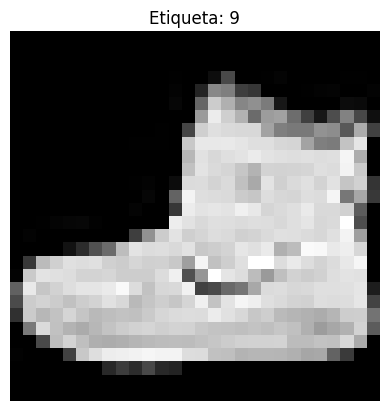

In [5]:
#Ahora quiero ver la foto renderizada en escala de grises
plt.imshow(img, cmap="grey", vmin=0, vmax=255)
plt.title(f"Etiqueta: {y_train_full_2[0]}")
plt.axis("off")
plt.show()

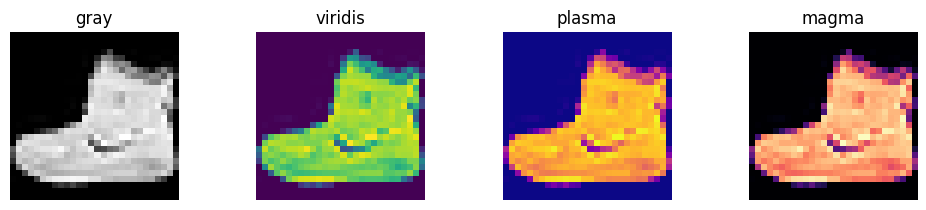

In [6]:
# --- Otros colores, colormaps de Matplotlib (viridis, plasma, magma, etc.) ---
plt.figure(figsize=(10, 2.2))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("gray"); plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(img, cmap="viridis", vmin=0, vmax=255)
plt.title("viridis"); plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img, cmap="plasma", vmin=0, vmax=255)
plt.title("plasma"); plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(img, cmap="magma", vmin=0, vmax=255)
plt.title("magma"); plt.axis("off")

plt.tight_layout()
plt.show()

RAW -> dtype: uint8 rango: (np.uint8(0), np.uint8(255))
NORM -> dtype: float32 rango: (np.float32(0.0), np.float32(1.0))


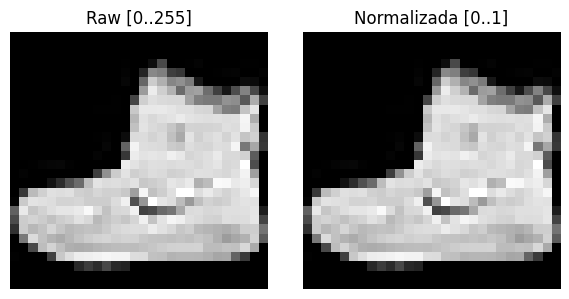

[0.         0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.7176471  0.88235295 0.84705883 0.8745098  0.89411765 0.92156863 0.8901961
 0.8784314  0.87058824 0.8784314  0.8666667  0.8745098  0.9607843  0.6784314  0.        ]
Se ve igual!!!!
Buena observación. Que se “vea igual” es lo esperado. Normalizar de 0..255 a 0..1 es una transformación lineal: conserva el contraste relativo.


In [7]:
#Normalizamos la foto y vemos como queda:
img = X_train_full_2[0]  # uint8 en [0,255], shape (28,28)

# Normalizar a [0,1] en float32
img_norm = img.astype(np.float32) / 255.0

print("RAW -> dtype:", img.dtype, "rango:", (img.min(), img.max()))
print("NORM -> dtype:", img_norm.dtype, "rango:", (img_norm.min(), img_norm.max()))

# Mostrar antes (raw) y después (normalizada)
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("Raw [0..255]")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_norm, cmap="gray", vmin=0, vmax=1)
plt.title("Normalizada [0..1]")
plt.axis("off")

plt.tight_layout()
plt.show()

print (img_norm[9])
print ("Se ve igual!!!!")
print ("Buena observación. Que se “vea igual” es lo esperado. Normalizar de 0..255 a 0..1 es una transformación lineal: conserva el contraste relativo.")

In [8]:
# 3) Carga y preparación de datos (Fashion-MNIST)
from tensorflow.keras.datasets import fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Normalizar a [0,1]
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Aplanar 28x28 -> 784 (para MLP)
#“Aplanar 28×28 → 784” = convertir la imagen 2D (28 filas × 28 columnas) en un vector 1D de 784 valores. ¿Por qué? Porque un MLP (capas densas) espera un vector de features por muestra; no entiende la estructura espacial 2D como una CNN.
X_train_full = X_train_full.reshape((X_train_full.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
#Al aplanar pierdes la información espacial (quién está al lado de quién). Por eso las CNN trabajan en 2D (Conv2D) y suelen rendir mejor en imágenes.
#Para MLP, aplanar es el paso estándar: cada píxel se vuelve una característica del vector.


# Split estratificado: mantiene las proporciones de clase
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

input_dim = X_train.shape[1]
num_classes = 10
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("Tamaño train:", X_train.shape, "\tTamaño val:", X_val.shape, "\tTamaño test:", X_test.shape)


#Explicación de las particiones de datos:
#(X_train_full, y_train_full): todo el train (imágenes y etiquetas).
#(X_test, y_test): test final (imágenes y etiquetas).
#(X_train, y_train) → el modelo aprende.
#(X_val, y_val) → el modelo se evalúa durante el entrenamiento (early stopping, tuning…).
#(X_test, y_test) → solo al final para reporte final.


Tamaño train: (48000, 784) 	Tamaño val: (12000, 784) 	Tamaño test: (10000, 784)


In [9]:
# 4) Construcción del MLP
def build_mlp(input_dim: int, num_classes: int = 10) -> keras.Model: #Define una función que construye y devuelvo un modelo Keras, input_dim: tamaño del vector de entrada (p. ej., 784 si 28x28 aplanado), num_classes: número de clases (10 en Fashion-MNIST).
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),                 # Capa de entrada "shape=(input_dim,)" indica que cada ejemplo es un vector de tamaño 784
        layers.Dense(128, activation="relu"),             # Capa densa (totalmente conectada) con 128 neuronas.  Activation="relu"
        layers.Dropout(0.2),                              # Apaga aleatoriamente el 20% de las neuronas durante el entrenamiento, Sirve como regularización para reducir sobreajuste (overfitting).
        layers.Dense(64, activation="relu"),              # Capa densa, ahora con 64 neuronas y ReLU.
        layers.Dense(num_classes, activation="softmax")   # Capa de salida: una neurona por clase. "softmax" convierte los 10 valores en probabilidades que suman 1.
    ])
    return model

model = build_mlp(input_dim=input_dim, num_classes=num_classes) #input_dim=784, num_classes=10
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Aplicado a tu resumen:

dense (Dense) → (None, 128)
Entradas = 784 (imagen 28×28 aplanada)
Unidades = 128
Parámetros = 784 × 128 = 100,352 + 128 = 100,480 ✅

dropout (Dropout)
No tiene pesos ni biases → 0 parámetros.

dense_1 (Dense) → (None, 64)
Entradas = 128 (sale de la capa anterior)
Unidades = 64
Parámetros = 128 × 64 = 8,192 + 64 = 8,256 ✅

dense_2 (Dense) → (None, 10)
Entradas = 64
Unidades (clases) = 10
Parámetros = 64 × 10  = 640 + 10 = 650 ✅

In [10]:
# 5) Entrenamiento con EarlyStopping
model.compile(optimizer="adam",                               #Optimizador optimizer="adam"
              loss="sparse_categorical_crossentropy",         #Es la pérdida adecuada para clasificación multiclase cuando tus etiquetas y son enteros
              metrics=["accuracy"])                           #Metrica a evaluar

#Early stop
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True   # Qué métrica miramos "val_loss", Cuántas épocas seguidas sin mejora toleramos 3, Al parar, volver a los pesos de la mejor época
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)
print("Entrenamiento finalizado.")


#optimizer="adam". Si pones el string "adam", Keras crea keras.optimizers.Adam() con valores por defecto típicos: learning_rate=1e-3 → tamaño de paso. Más grande = aprende más rápido pero puede inestabilizarse; más pequeño = más estable pero lento.
#beta_1=0.9 y beta_2=0.999 → suavizado exponencial de medias/varianzas de gradiente.
#epsilon=1e-7 → evita divisiones por cero (estabilidad numérica).

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6878 - loss: 0.8937 - val_accuracy: 0.8484 - val_loss: 0.4254
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8365 - loss: 0.4550 - val_accuracy: 0.8676 - val_loss: 0.3685
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8558 - loss: 0.4018 - val_accuracy: 0.8733 - val_loss: 0.3502
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8653 - loss: 0.3712 - val_accuracy: 0.8792 - val_loss: 0.3366
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8709 - loss: 0.3511 - val_accuracy: 0.8799 - val_loss: 0.3317
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8751 - loss: 0.3378 - val_accuracy: 0.8845 - val_loss: 0.3281
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8819 - loss: 0.3190 - val_accuracy: 0.8801 - val_loss: 0.3283
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8826 - loss: 0.3157 - val_accuracy: 

In [11]:
#Qué significa cada cosa
#375/375: número de batches procesados en el train durante esta época.
#accuracy: 0.6878 → Exactitud en TRAIN (68.78%). Proporción de ejemplos de entrenamiento clasificados correctamente.
#loss: 0.8937 → Pérdida en TRAIN (cross-entropy). Mide “qué tan mal” están las probabilidades que da el modelo. Más baja = mejor.
#val_accuracy: 0.8484 → Exactitud en VALIDACIÓN (84.84%).Igual que accuracy, pero en datos no vistos durante el entrenamiento.
# val_loss: 0.4254 → Pérdida en VALIDACIÓN. Igual que la loss de train pero calculada en el set de validación.

Loss (test): 0.3557
Accuracy (test): 0.8737

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8299    0.8150    0.8224      1000
           1     0.9908    0.9700    0.9803      1000
           2     0.7814    0.7830    0.7822      1000
           3     0.8521    0.8930    0.8721      1000
           4     0.7190    0.8520    0.7799      1000
           5     0.9736    0.9590    0.9662      1000
           6     0.7487    0.5870    0.6581      1000
           7     0.9110    0.9730    0.9410      1000
           8     0.9622    0.9670    0.9646      1000
           9     0.9751    0.9380    0.9562      1000

    accuracy                         0.8737     10000
   macro avg     0.8744    0.8737    0.8723     10000
weighted avg     0.8744    0.8737    0.8723     10000



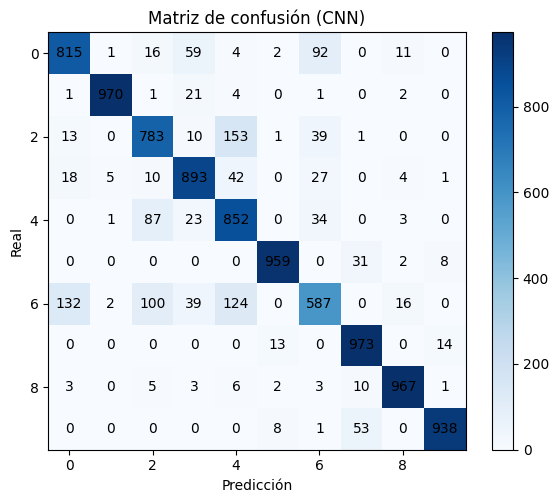

In [12]:
# 6) Evaluación en test + reporte
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (test): {loss:.4f}")
print(f"Accuracy (test): {acc:.4f}")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión (CNN)")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()


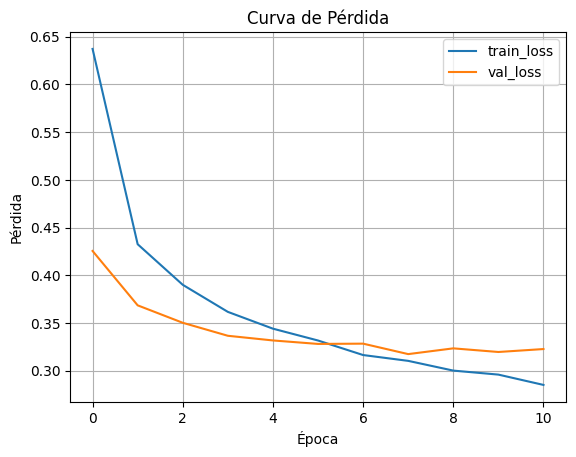

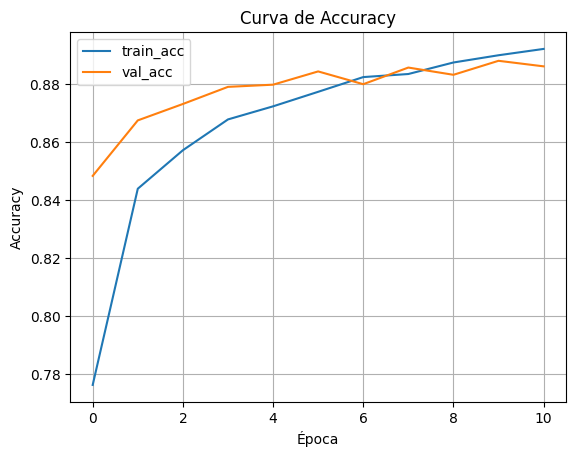

In [13]:
# 7) Curvas de aprendizaje (pérdida y accuracy)
hist = history.history

#Cuanto más baja mejor
plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva de Pérdida"); plt.legend(); plt.grid(True)
plt.show()

#Cuanto más alto, mejor.
plt.figure()
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Curva de Accuracy"); plt.legend(); plt.grid(True)
plt.show()


Consejos rapidos

Gap grande (train mucho mejor que val) → regulariza (Dropout, L2), menos capacidad, EarlyStopping.

Ambas malas → más capacidad/épocas o ajusta LR; revisa datos/normalización.

Oscila → reduce LR, usa batch más grande o clipping de gradiente.

Se estanca pronto → sube LR un poco o usa scheduler (ReduceLROnPlateau).

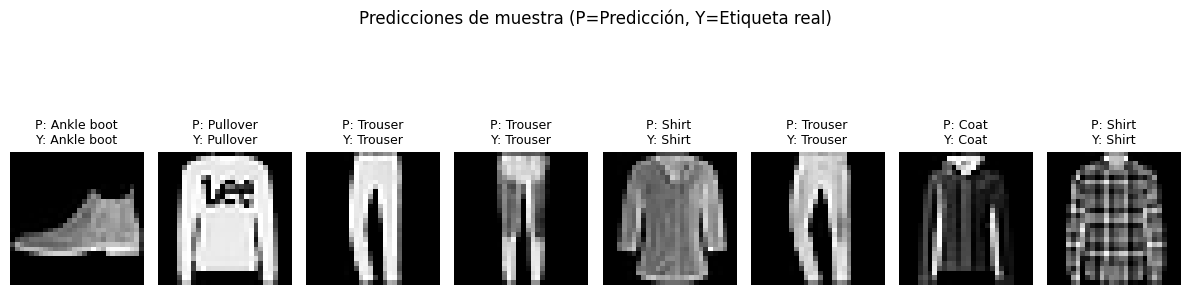

In [14]:
# 8) Predicciones de muestra
num_samples = 8
idx = np.arange(0, num_samples)
X_subset = X_test[idx]
y_subset = y_test[idx]

y_probs = model.predict(X_subset, verbose=0)
y_pred = np.argmax(y_probs, axis=1)

images = X_subset.reshape((-1, 28, 28))

plt.figure(figsize=(12, 4))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i], cmap="gray")
    title = f"P: {class_names[y_pred[i]]}\nY: {class_names[y_subset[i]]}"
    plt.title(title, fontsize=9)
    plt.axis("off")
plt.suptitle("Predicciones de muestra (P=Predicción, Y=Etiqueta real)")
plt.tight_layout()
plt.show()
